# Astronomical Coordinates 3: Cross-matching Catalogs Using astropy.coordinates and astroquery

## Authors
Adrian Price-Whelan

## Learning Goals
* TODO

## Keywords
coordinates, astroquery


## Summary

In the previous tutorials in this series, we introduced many of the key concepts underlying how to represent and transform astronomical coordinates using `astropy.coordinates`.

In this tutorial, we will explore how the `astropy.coordinates` package can be used to transform astronomical coordinates between different coordinate systems or frames. You may find it helpful to keep [the Astropy documentation for the coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html) open alongside this tutorial for reference or additional reading. In the text below, you may also see some links that look like ([docs](http://docs.astropy.org/en/stable/coordinates/index.html)). These links will take you to parts of the documentation that are directly relevant to the cells from which they link. 

*Note: This is the 3rd tutorial in a series of tutorials about astropy.coordinates. If you are new to astropy.coordinates, you may want to start from the beginning or an earlier tutorial.*
- [Previous tutorial: Astronomical Coordinates 2: Transforming Coordinate Systems and Representations](2-Coordinates-Transforms)
- [Next tutorial: Astronomical Coordinates 4 - Working with Velocity Data](4-Coordinates-Velocities)

## Imports

We start by importing some general packages that we will need below:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file

## Cross-matching and comparing catalogs

Let's recap what we have done so far: We defined a `SkyCoord` object to represent the center of an open cluster (NGC 188), we queried the *Gaia* DR2 catalog to select stars that are close (on the sky) to the center of the cluster, and we used the parallax values from *Gaia* to select stars that are near NGC 188 in 3D position.

Imagine that we now want to cross-match our catalog of candidate members of NGC 188 to another catalog: Here we will cross-match the *Gaia* stars with the 2MASS photometric catalog to retrieve infrared magnitudes for these stars, and then plot a color-magnitude diagram. To do this, we first need to query the 2MASS catalog to retrieve all sources in a region around the center of NGC 188, as we did for *Gaia*. We will once again use `astroquery` to execute this query. This will again require an internet connection, but we have again included the results of this query in a file along with this notebook in case you are not connected to the internet.

To query 2MASS, we will use the `astroquery.vizier` module ([docs](https://astroquery.readthedocs.io/en/latest/vizier/vizier.html)):

In [28]:
from astroquery.vizier import Vizier

In [29]:
# NOTE: skip this cell if you do not have an internet connection

# II/246 is the catalog name for the main 2MASS photometric catalog
v = Vizier(catalog="II/246")  
v.ROW_LIMIT = -1

result = v.query_region(ngc188_center, radius=0.5*u.deg)
tmass_table = result[0]

In [31]:
tmass_table = QTable.read('2MASS_results.fits')

As with the *Gaia* results table, we can now create a single `SkyCoord` object to represent all of the sources returned from our query to the 2MASS catalog. Let's look at the column names in this table by displaying the first few rows:

In [32]:
tmass_table[:3]

RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,bytes17,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes3,bytes3,uint8,uint8
9.633532,84.808350,00383204+8448300,13.079,0.030,12.742,0.033,12.729,0.035,AAA,222,111,000,0,0
8.562472,84.873627,00341499+8452250,14.459,0.029,14.103,0.041,14.166,0.063,AAA,222,111,000,0,0
8.645318,84.868584,00343487+8452069,10.356,0.026,10.057,0.032,10.000,0.020,AAA,222,111,000,0,0


From looking at the column names, it looks like the two relevant sky coordinate columns are `RAJ2000` for `ra` and `DEJ2000` for `dec`:

In [33]:
tmass_coords = SkyCoord(tmass_table['RAJ2000'], 
                        tmass_table['DEJ2000'])
len(tmass_coords)

5014

We now want to cross-match our *Gaia*-selected candidate members of NGC 188 with this table of photometry from 2MASS. Let's first use the mask we defined above (in the exercise) to select members of NGC 188 based on 3D position:

In [34]:
ngc188_3d_mask = sep3d < 50*u.pc
gaia_ngc188_members = gaia_coords_3d[ngc188_3d_mask]
gaia_ngc188_members_table = table_3d[ngc188_3d_mask]

Now we can use the ``SkyCoord.match_to_catalog_sky`` method to match the two catalogs ([docs](http://docs.astropy.org/en/latest/coordinates/matchsep.html#astropy-coordinates-matching)). Note that order matters: Here we are matching 2MASS to *Gaia* because we ultimately want to make a color-magnitude diagram using the 2MASS photometry. `SkyCoord.match_to_catalog_sky` returns three objects: first, the indices into `gaia_ngc188_members` that get the closest matches in `tmass_coords`, second, the angular separation between each `tmass_coords` coordinate and the closest source in `gaia_ngc188_members`, and finally, the 3D distance between each `tmass_coords` coordinate and the closest source in `gaia_ngc188_members`. Here, the 3D distances will not be useful because the 2MASS coordinates do not have associated distance information:

In [35]:
idx_tmass, d2d_tmass, d3d_tmass = tmass_coords.match_to_catalog_sky(gaia_ngc188_members)

Let's now look at the distribution of separations for all of the cross-matched sources:

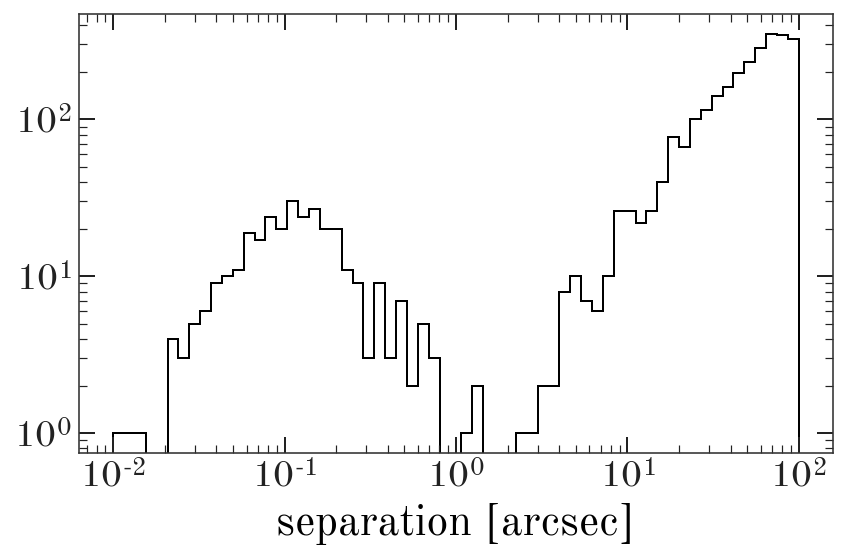

In [36]:
plt.hist(d2d_tmass.arcsec, histtype='step', 
         bins=np.logspace(-2, 2., 64))
plt.xlabel('separation [arcsec]')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

From this, it looks like the sources that actually match to our *Gaia* NGC 188 members are all within about 2 arcseconds, so that is promising! How many of the 2MASS sources matched to one of our NGC 188 candidate members?

In [37]:
(d2d_tmass < 2*u.arcsec).sum()

309

That is a large fraction of the 321 members we identified. Missing sources may be too faint for 2MASS to detect, so we do not expect all of the *Gaia* sources to be in 2MASS. With our cross-match done, we can now make 2MASS+Gaia color-magnitude diagrams of our candidate NGC 188 members:

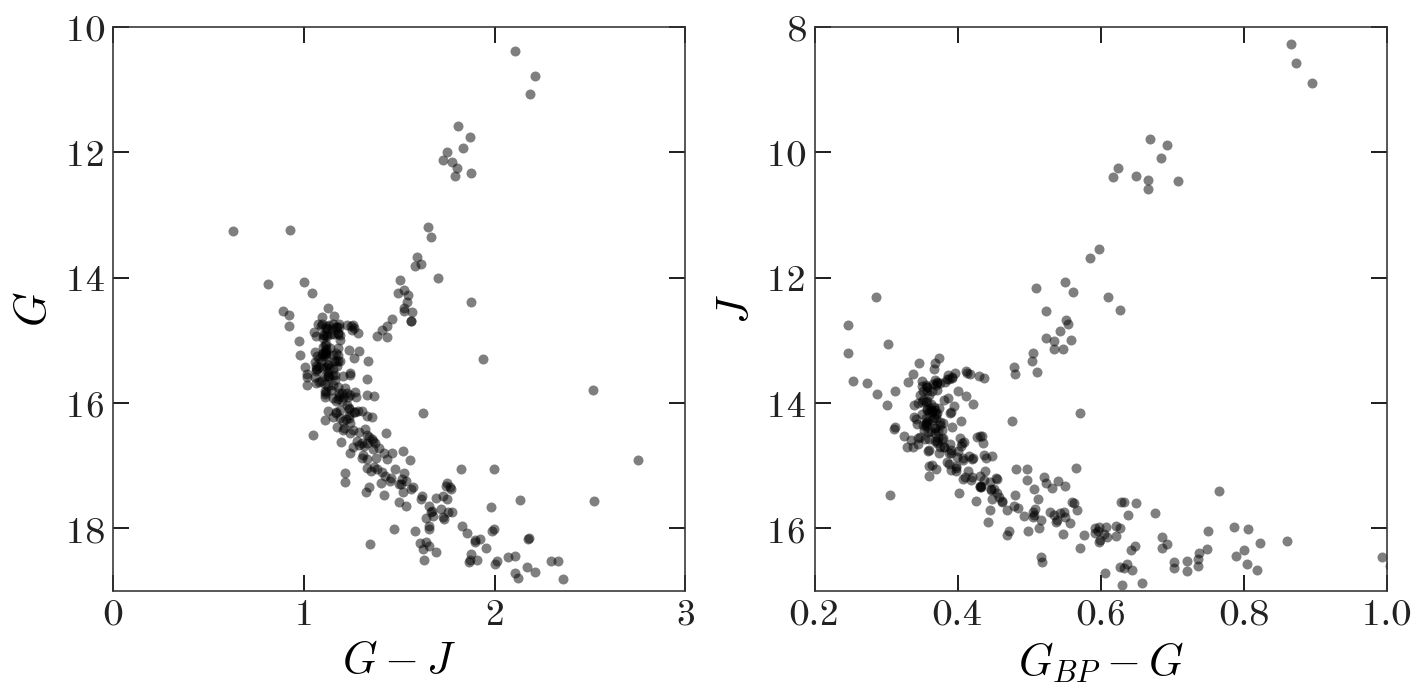

In [38]:
Jmag = tmass_table['Jmag'][d2d_tmass < 2*u.arcsec]
Gmag = gaia_ngc188_members_table['phot_g_mean_mag'][idx_tmass[d2d_tmass < 2*u.arcsec]]
Bmag = gaia_ngc188_members_table['phot_bp_mean_mag'][idx_tmass[d2d_tmass < 2*u.arcsec]]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(Gmag - Jmag, Gmag, 
           marker='o', color='k', 
           linewidth=0, alpha=0.5)
ax.set_xlabel('$G - J$')
ax.set_ylabel('$G$')
ax.set_xlim(0, 3)
ax.set_ylim(19, 10) # backwards because magnitudes!

ax = axes[1]
ax.scatter(Bmag - Gmag, Jmag, 
           marker='o', color='k', 
           linewidth=0, alpha=0.5)
ax.set_xlabel('$G_{BP} - G$')
ax.set_ylabel('$J$')
ax.set_xlim(0.2, 1)
ax.set_ylim(17, 8) # backwards because magnitudes!

fig.tight_layout()

Those both look like color-magnitude diagrams of a main sequence + red giant branch of an intermediate-age stellar cluster, so it looks like our selection and cross-matching has worked!

For more on what matching options are available, check out the [separation and matching section of the Astropy documentation](https://astropy.readthedocs.io/en/stable/coordinates/matchsep.html). Or for more on what you can do with `SkyCoord`, see [its API documentation](http://astropy.readthedocs.org/en/stable/api/astropy.coordinates.SkyCoord.html).

### Exercises

Using the coordinates of the center of the Pleiades you defined in the previous set of exercises, download a catalog of 2MASS sources within 1 degree of the center of the Pleiades. Make a color-magnitude diagram of J-H vs. J for all sources. Can you see the main sequence corresponding to the Pleiades?

In [39]:
v = Vizier(catalog="II/246")  
v.ROW_LIMIT = -1

result = v.query_region(pleiades_center, radius=1*u.deg)
tmass_table_pleiades = result[0]

(12.0, 2.0)

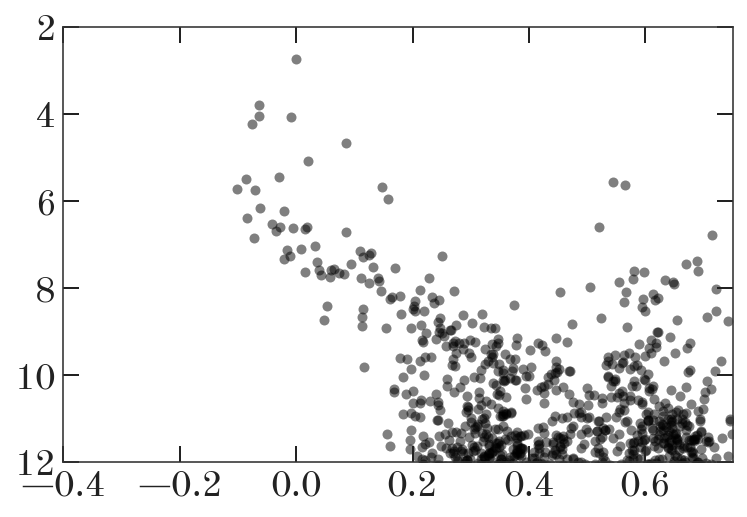

In [40]:
Jmag_p = tmass_table_pleiades['Jmag']
Hmag_p = tmass_table_pleiades['Hmag']

plt.scatter(Jmag_p - Hmag_p, Jmag_p,
            marker='o', color='k', 
            linewidth=0, alpha=0.5)
plt.xlim(-0.4, 0.75)
plt.ylim(12, 2)

Again using the coordinates of the center of the Pleiades, now download all *Gaia* sources within 1 degree of the center of the Pleiades. Cross-match the 2MASS and *Gaia* sources, and make a G-J vs. G color-magnitude diagram of all sources within 200 parsecs of the Sun.

In [49]:
Gaia.ROW_LIMIT = 10_000
job = Gaia.cone_search_async(pleiades_center, radius=1*u.deg)
gaia_table_pleiades = job.get_results()

# This might produce a bunch of warnings: you can ignore these!
gaia_table_pleiades = QTable(gaia_table_pleiades[gaia_table_pleiades['parallax'] > 0])

INFO: Query finished. [astroquery.utils.tap.core]


In [53]:
tmass_ple_coords = SkyCoord(tmass_table_pleiades['RAJ2000'],
                            tmass_table_pleiades['DEJ2000'])

gaia_ple_coords = SkyCoord(gaia_table_pleiades['ra'],
                           gaia_table_pleiades['dec'],
                           Distance(parallax=gaia_table_pleiades['parallax']))

(19.0, 0.0)

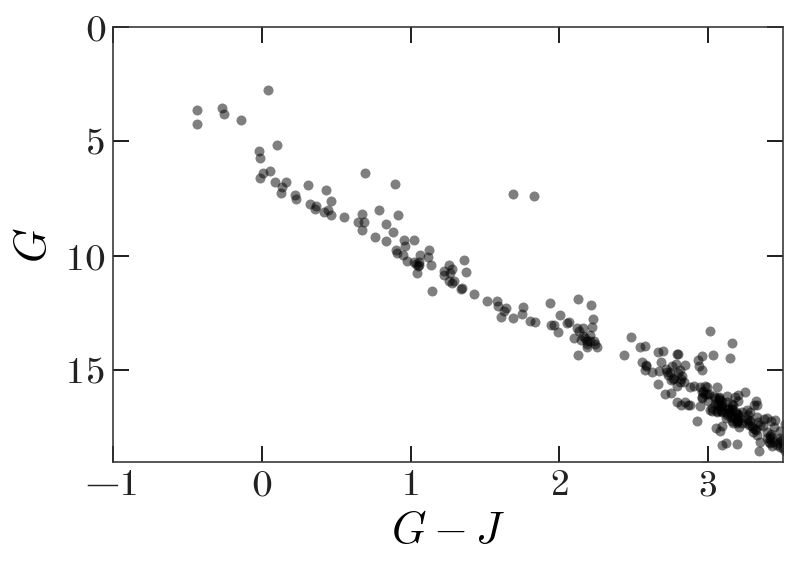

In [54]:
idx_ple, d2d_ple, _ = gaia_ple_coords.match_to_catalog_sky(tmass_ple_coords)

sep_mask = (d2d_ple < 2*u.arcsec) & (gaia_ple_coords.distance < 200*u.pc)

Gmag_ple = gaia_table_pleiades[sep_mask]['phot_g_mean_mag']
Jmag_ple = tmass_table_pleiades[idx_ple[sep_mask]]['Jmag']

plt.scatter(Gmag_ple - Jmag_ple, Gmag_ple, 
            marker='o', color='k', 
            linewidth=0, alpha=0.5)
plt.xlabel('$G - J$')
plt.ylabel('$G$')
plt.xlim(-1, 3.5)
plt.ylim(19, 0)  # backwards because magnitudes!

In this tutorial, we have introduced `astropy.coordinates` as a way to store and represent astronomical sky coordinates. We used coordinate objects, via the `SkyCoord` class interface, to parse and change coordinate representations and units. We also demonstrated how to cross-match 